In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the transforms to be applied to the data
# Here, assume that the images are grayscale and need to be resized to 32x32
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the custom dataset
# Here, assume that the dataset is stored in the following directories:
# - train: contains training images
# - test: contains testing images
train_data = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_full/train", transform=transform)
test_data = datasets.ImageFolder(root="E:/Project_A/project_share/Project_A_image_full/class", transform=transform)
train_size = int (0.875*len(train_data))
train_dataset = data.Subset(train_data,range(train_size))
# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [3]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, pool_proj):
        super(InceptionModule, self).__init__()
        
        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)
        
        # 3x3 convolution branch
        self.branch3x3_reduce = nn.Conv2d(in_channels, reduce3x3, kernel_size=1)
        self.branch3x3 = nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)
        
        # 5x5 convolution branch
        self.branch5x5_reduce = nn.Conv2d(in_channels, reduce5x5, kernel_size=1)
        self.branch5x5 = nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)
        
        # Max pooling branch
        self.branch_pool = nn.Conv2d(in_channels, pool_proj, kernel_size=1)
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_reduce(x)
        branch3x3 = self.branch3x3(branch3x3)
        
        branch5x5 = self.branch5x5_reduce(x)
        branch5x5 = self.branch5x5(branch5x5)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

In [10]:
# Define the model architecture
class custom_net(nn.Module):
    def __init__(self):
        super(custom_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.inception3a = InceptionModule(16, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.fc1 = nn.Linear(480*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.avgpool2(x)
        # Apply Inception module
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = torch.relu(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x
# Create the model instance and set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = custom_net().to(device)

# Define the loss function, optimizer, and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
# Train the model
epochs = 6
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0


Epoch: 1, Batch: 100, Loss: 1.454
Epoch: 1, Batch: 200, Loss: 1.328
Epoch: 1, Batch: 300, Loss: 1.305
Epoch: 1, Batch: 400, Loss: 1.252
Epoch: 1, Batch: 500, Loss: 1.185
Epoch: 1, Batch: 600, Loss: 1.034
Epoch: 1, Batch: 700, Loss: 0.914
Epoch: 2, Batch: 100, Loss: 0.833
Epoch: 2, Batch: 200, Loss: 0.781
Epoch: 2, Batch: 300, Loss: 0.716
Epoch: 2, Batch: 400, Loss: 0.680
Epoch: 2, Batch: 500, Loss: 0.664
Epoch: 2, Batch: 600, Loss: 0.640
Epoch: 2, Batch: 700, Loss: 0.597
Epoch: 3, Batch: 100, Loss: 0.546
Epoch: 3, Batch: 200, Loss: 0.566
Epoch: 3, Batch: 300, Loss: 0.532
Epoch: 3, Batch: 400, Loss: 0.481
Epoch: 3, Batch: 500, Loss: 0.493
Epoch: 3, Batch: 600, Loss: 0.458
Epoch: 3, Batch: 700, Loss: 0.472
Epoch: 4, Batch: 100, Loss: 0.423
Epoch: 4, Batch: 200, Loss: 0.405
Epoch: 4, Batch: 300, Loss: 0.459
Epoch: 4, Batch: 400, Loss: 0.416
Epoch: 4, Batch: 500, Loss: 0.400
Epoch: 4, Batch: 600, Loss: 0.398
Epoch: 4, Batch: 700, Loss: 0.412
Epoch: 5, Batch: 100, Loss: 0.388
Epoch: 5, Batc

In [6]:
# Evaluate the model
model.eval()

# Create empty lists to store the predicted labels and ground truth labels
pred_labels = []
true_labels = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_labels += predicted.tolist()
        true_labels += labels.tolist()

print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

Accuracy of the model on the test images: 86.89%


f1 = 0.8655963763162461


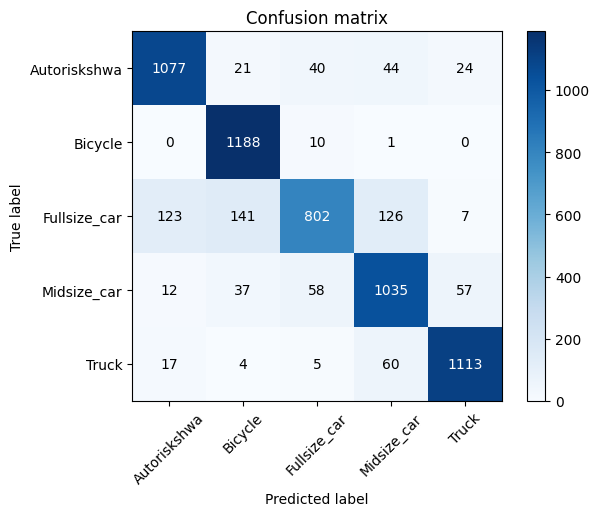

In [7]:

# calculate the confusion matrix using scikit-learn
cm = confusion_matrix(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='macro')
print(f"f1 = {f1}")
# Define class labels and tick marks
class_names = ['Autoriskshwa', 'Bicycle','Fullsize_car','Midsize_car','Truck']
tick_marks = np.arange(len(class_names))

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()

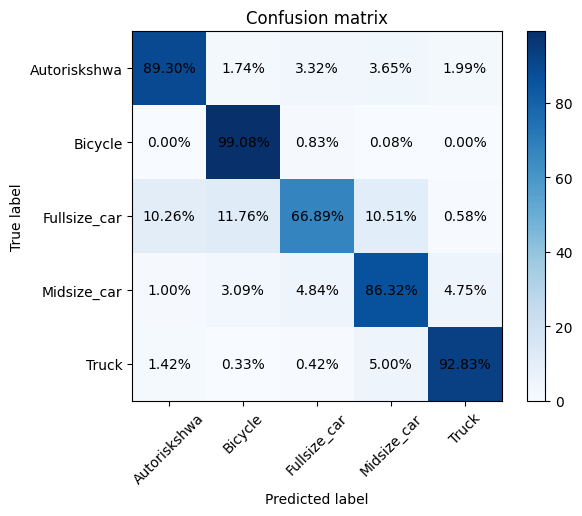

In [8]:
# Calculate the percentage of predictions for each class
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Define class labels and tick marks
class_names = ['Autoriskshwa', 'Bicycle','Fullsize_car','Midsize_car','Truck']
tick_marks = np.arange(len(class_names))

# Plot confusion matrix
plt.imshow(cm_perc, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

# Add labels to the plot
thresh = cm_perc.max() / 2.
for i, j in np.ndindex(cm_perc.shape):
    plt.text(j, i, format(cm_perc[i, j], '.2f') + '%',
             ha="center", va="center",
             color="black" )

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display the plot
plt.show()